In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


By opening the file that way, the Chinese characters will be removed:

In [2]:
with open('../data/labelled_save.csv', encoding='ascii', errors='ignore') as myfile:
    abstracts = pd.read_csv(myfile, index_col=0)

In [3]:
with open('../data/no_signi_abstracts.csv', encoding='ascii', errors='ignore') as myfile:
    noa = pd.read_csv(myfile, index_col=0)

In [4]:
abstracts.head()

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts,significant
0,quality of life in hypoparathyroidism. vokes t...,30261328,2018.0,Bone,Quality of life in hypoparathyroidism,VokesT,VokesT,0.0,0.0,Hypoparathyroidism is a rare endocrine disorde...,0.0
1,vitamin d status and its association with seas...,30261231,2018.0,Neurosci Lett,Vitamin D status and its association with seas...,GuY ZhuZ LuanX HeJ,HeJ,1.0,0.0,BACKGROUND: Vitamin D plays a key role in depr...,yes
3,"vitamin d levels in active tb, latent tb, non-...",30260729,2018.0,Fetal Pediatr Pathol,Vitamin D Levels in Active TB Latent TB Non-TB...,BuonsensoD SaliM PataD MasielloE SalernoG Cecc...,ValentiniP,0.0,0.0,BACKGROUND: Growing evidence suggests that vit...,yes
6,correlation of vitamin d binding protein gene ...,30259785,2018.0,Per Med,Correlation of vitamin D binding protein gene ...,ChuaychooB TungtrongchitrR KriengsinyosW Tunti...,ChupeerachC,0.0,0.0,AIM: The risk of vitamin D binding protein (DB...,both
7,vitamin d status including 3-epi-25(oh)d3 amon...,30259504,2018.0,Endokrynol Pol,Vitamin D status including 3-epi-25OHD3 among ...,KmieP MinkiewiczI SworczakK mijewskiMA KowalskiK,KowalskiK,1.0,0.0,INTRODUCTION: In the context of pleiotropic vi...,yes


### Cleaning of abstracts
Abstracts which are shorter than 500 characters (see labelling_of_significance_of_results for details) are removed, numbers in words are transformed to a synonyme and words are fused or expanded to not be removed by the cleaning, numbers are removed, punctuation is removed and words shorter than three characters are removed.

In [5]:
def easy_words(column):
    text = column.str.lower()
    
    text = text.str.replace('1,25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25\S+ vit d', 'calcitriol')
    text = text.str.replace('1,25\S+', 'calcitriol')

    text = text.str.replace('1,25 vitamin d', 'calcitriol')
    text = text.str.replace('1,25 vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ d', 'calcitriol')
    text = text.str.replace('1,25 \S+', 'calcitriol')
    
    text = text.str.replace('25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('25\S+ vit d', 'calcitriol')
    text = text.str.replace('25\S+', 'calcitriol')
 
    text = text.str.replace('vitamin d', 'vitamind')
    text = text.str.replace('vit d', 'vitamind')
    
    text = text.str.replace('tb', 'tuberculosis')
    
    return text

In [6]:
abstracts['abstract'] = easy_words(abstracts['abstract'])

In [7]:
abstracts['abstract'] = abstracts.abstract.str.replace('\d+', '')

In [8]:
abstracts['abstract'] = abstracts.abstract.str.replace('[^\w\s]', '')

In [9]:
abstracts['abstract'] = abstracts.abstract.str.findall('\w{3,}').str.join(' ')

### Split labelled from unlabelled data

In [10]:
unlabelled_abstracts = abstracts[abstracts['significant'] == '0.0']
unlabelled_abstracts = unlabelled_abstracts.drop('significant', axis=1)

labelled_abstracts = abstracts[abstracts['significant'] != '0.0']

In [11]:
print(f'{len(labelled_abstracts)} labelled abstracts.')
print(f'{len(unlabelled_abstracts)} unlabelled abstracts.')

20751 labelled abstracts.
2993 unlabelled abstracts.


### Splitting data in train, validate, test

In [12]:
def split_train_val_test(data, targetname, percentages):
    """percentages = list with percentage of train,val,test. e.g. [0.6,0.2,0.2]
    targetname = column name of target (string). data is a dataframe"""
    train_perc = percentages[0]
    test_perc = percentages[2]
    val_perc = test_perc/(train_perc + test_perc)

    if sum(percentages) != 1:
        print('percentages don\'t sum up to more than 1! calculate again :) ')
        return None
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            data.loc[:, data.columns != targetname], data[targetname],
            test_size=test_perc, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_perc, random_state=42)
        return [X_train, X_val, X_test, y_train, y_val, y_test]

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(labelled_abstracts, 'significant',
                                                                      [0.7, 0.15, 0.15])

In [14]:
X_train.to_csv('../data/X_train.csv')
X_val.to_csv('../data/X_val.csv')
X_test.to_csv('../data/X_test.csv')
y_train.to_csv('../data/y_train.csv')
y_val.to_csv('../data/y_val.csv')
y_test.to_csv('../data/y_test.csv')

### CountVectorizing vs. TF-IDF for getting a word/frequency matrix
min_df was set to 0.02 to ensure the very low frequency words (in our case probably authors and university names) are removed.

In [15]:
cv = CountVectorizer(min_df=0.02, max_features=300000, stop_words='english').fit(X_train['abstract'])

In [16]:
tf = TfidfVectorizer(min_df=0.02, max_features=300000, stop_words='english').fit(X_train['abstract'])

In [17]:
def count_vect(series):
    matrix = cv.transform(series)
    features = cv.get_feature_names()
    df = pd.DataFrame(matrix.todense(), columns=features)
    return df


def tf_idf(series):
    matrix = tf.transform(series)
    features = tf.get_feature_names()
    df = pd.DataFrame(matrix.todense(), columns=features)
    return df

In [18]:
cv_train_df = count_vect(X_train['abstract'])
cv_val_df = count_vect(X_val['abstract'])
cv_test_df = count_vect(X_test['abstract'])

In [19]:
cv_train_df.head()

,ability,abnormal,abnormalities,absence,absorptiometry,absorption,according,achieved,acid,action,...,white,winter,women,womens,xray,year,years,york,young,zhang
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [20]:
tf_train_df = tf_idf(X_train['abstract'])
tf_val_df = tf_idf(X_val['abstract'])
tf_test_df = tf_idf(X_test['abstract'])

In [21]:
tf_train_df.head()

,ability,abnormal,abnormalities,absence,absorptiometry,absorption,according,achieved,acid,action,...,white,winter,women,womens,xray,year,years,york,young,zhang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.024462,0.0,0.0,0.0,0.045613,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.065069,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084945,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.053482,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071501,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.032993,0.0,0.0,0.0


### Checking for linearity

In [22]:
cv_train_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [23]:
cv_df = pd.concat((cv_train_df, y_train), axis=1)

In [24]:
tf_train_df.reset_index(drop=True, inplace=True)

In [25]:
tf_df = pd.concat((tf_train_df, y_train), axis=1)

In [26]:
corr_matrix = cv_df.corr()
corr_matrix['significant'].sort_values(ascending=False)

significant          1.000000
statistically        0.238866
difference           0.210694
differences          0.168907
observed             0.153087
correlation          0.138612
decrease             0.121923
increase             0.117372
association          0.107930
showed               0.107471
improvement          0.105747
study                0.105730
changes              0.104213
reduction            0.103014
iran                 0.100284
groups               0.099673
placebo              0.095409
correlations         0.087057
randomized           0.086873
postmenopausal       0.085816
spine                0.082522
trial                0.080910
bmd                  0.080126
lumbar               0.078980
positive             0.077567
change               0.077559
placebocontrolled    0.077337
group                0.077214
included             0.077192
inverse              0.077186
                       ...   
tissue              -0.037661
differentiation     -0.038333
differ    

In [27]:
corr_matrix = tf_df.corr()
corr_matrix['significant'].sort_values(ascending=False)

significant        1.000000
statistically      0.210724
difference         0.202602
differences        0.153528
observed           0.145819
decrease           0.139286
correlation        0.133547
increase           0.125072
improvement        0.114183
changes            0.106555
showed             0.104684
reduction          0.098633
groups             0.085197
association        0.082822
correlations       0.075500
resulted           0.075324
effect             0.072395
positive           0.068012
change             0.067706
seen               0.067186
study              0.066742
iran               0.065418
author             0.062402
months             0.060683
inverse            0.059645
clinically         0.057690
placebo            0.057543
parameters         0.054779
information        0.054641
metaanalysis       0.054540
                     ...   
diet              -0.038605
mouse             -0.039252
protein           -0.039497
fold              -0.039540
school            -0

There is a weak linear correlation between statistically, difference, significantly, differences, observed, 
correlation, reduction, increase, decrease, showed, association, improvement, study and the target - not surprisingly as these words are usually part of a statement of significance.

### MVP - Logistic Regression
- Logistic Regression is a first, easy model to classify data
- there is a linear relationship between three features and the target

Using count vectorized input data.

In [28]:
logreg_cv = LogisticRegression(random_state=42).fit(cv_train_df, y_train)

In [29]:
def cm(y_train, y_train_predict, y_val, y_val_predict):
    cm_train = confusion_matrix(y_train, y_train_predict, labels=['yes', 'no', 'both'])
    cm_train_percentage = cm_train/(cm_train.sum(axis=1, keepdims=True))

    cm_val = confusion_matrix(y_val, y_val_predict, labels=['yes', 'no', 'both'])
    cm_val_percentage = cm_val/(cm_val.sum(axis=1, keepdims=True))
    
    sns.set(font_scale=1.3)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.heatmap(cm_train_percentage, annot=True, xticklabels=['yes', 'no', 'both'],
                yticklabels=['yes', 'no', 'both'], fmt='.2f')
    plt.title('TRAIN')
    plt.subplot(1,2,2)
    sns.heatmap(cm_val_percentage, annot=True, xticklabels=['yes', 'no', 'both'],
                yticklabels=['yes', 'no', 'both'], fmt='.2f')
    plt.title('VALIDATE')
    plt.show()
    
    
def evaluate_model(model, X_train, y_train, X_val, y_val):
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    
    print(f'Accuracy for predicting the train labels: {np.round(train_score, decimals=2)}')
    print(f'Accuracy for predicting the validate labels: {np.round(val_score, decimals=2)}')
    
    predict_train = model.predict(X_train)
    predict_val = model.predict(X_val)
    
    cm(y_train, predict_train, y_val, predict_val)
    
    print(classification_report(y_val, predict_val))

Accuracy for predicting the train labels: 0.79
Accuracy for predicting the validate labels: 0.76


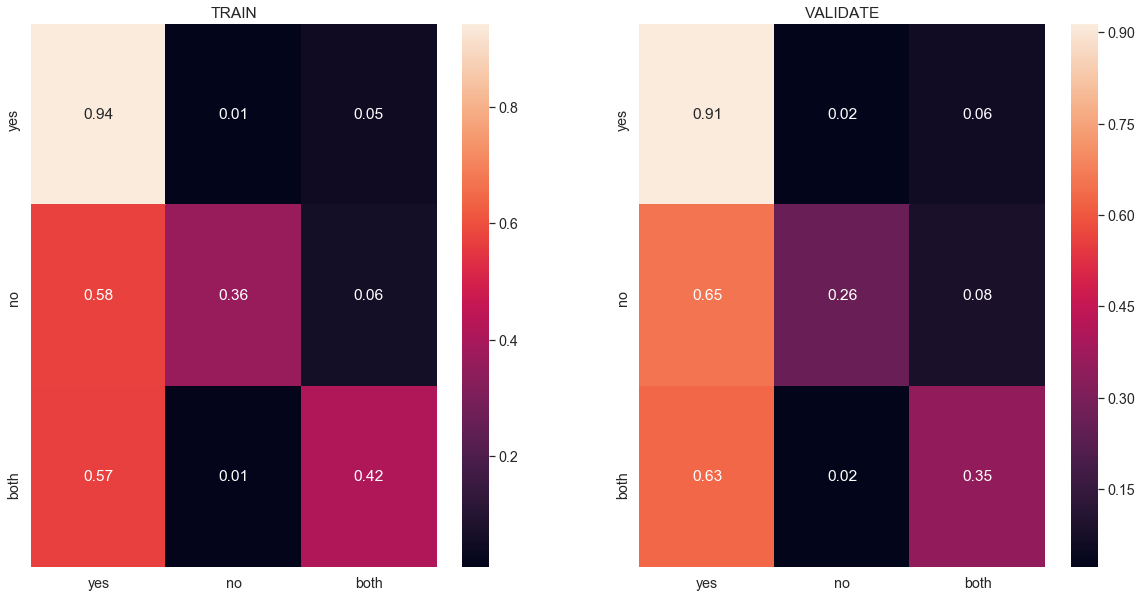

             precision    recall  f1-score   support

       both       0.59      0.35      0.44       645
         no       0.42      0.26      0.32       193
        yes       0.80      0.91      0.85      2275

avg / total       0.73      0.76      0.73      3113



In [30]:
evaluate_model(logreg_cv, cv_train_df, y_train, cv_val_df, y_val)

Most of the 'yes' papers were correctly classified (92 %), however, 'no' (18 %) and 'both' (33 %) posed difficulties, especially 'no'. Maybe this is because the major proportion of papers in the training data are labelled as 'yes'.

Precision: 69 % is correctly classified as 'both', 32 % is classified as 'both' even though it's truly 'no' or 'yes'.

Recall: 24 % is correctly classified as both, but 76 % of 'both' is wrongly classified as 'yes' or 'no'.

f1-score: harmonic mean of precision and recall.

#### Logistic regression is trained with TF-IDF pre-processed data.

In [31]:
logreg_tf = LogisticRegression(random_state=42).fit(tf_train_df, y_train)

Accuracy for predicting the train labels: 0.76
Accuracy for predicting the validate labels: 0.75


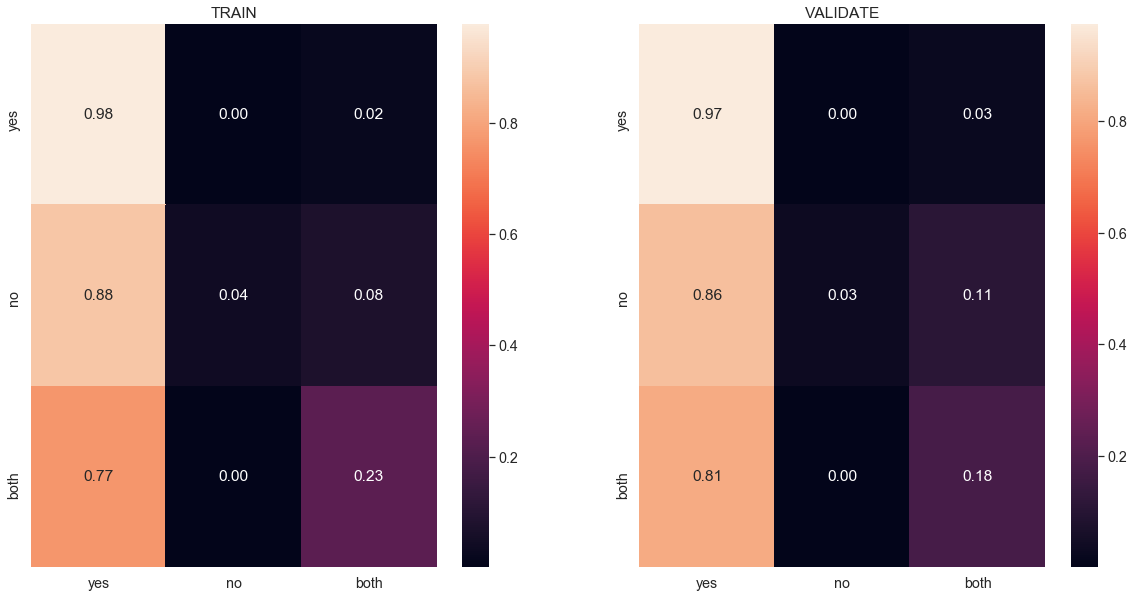

             precision    recall  f1-score   support

       both       0.60      0.18      0.28       645
         no       0.67      0.03      0.06       193
        yes       0.76      0.97      0.86      2275

avg / total       0.72      0.75      0.69      3113



In [32]:
evaluate_model(logreg_tf, tf_train_df, y_train, tf_val_df, y_val)

TF-IDF was better with classifying the 'yes' (97 % correct), however much worse with 'no' (1.3 % correct) and 'both' (17% correct). CountVectorize will be used for data preprocessing from here on out.

### Support Vector Machines
- Support Vector Machines do very well on wide data (lots of features) without overfitting
- they are able to work with unbalanced classes by balancing them automatically as is the case with this data
- This paper (http://www.cs.cornell.edu/~tj/publications/joachims_98a.pdf) suggested the kernel 'poly' and 'rbf' work very well for text

In [33]:
sv_poly = SVC(kernel='poly', class_weight='balanced', C=1.0, random_state=42).fit(cv_train_df, y_train)

Accuracy for predicting the train labels: 0.77
Accuracy for predicting the validate labels: 0.71


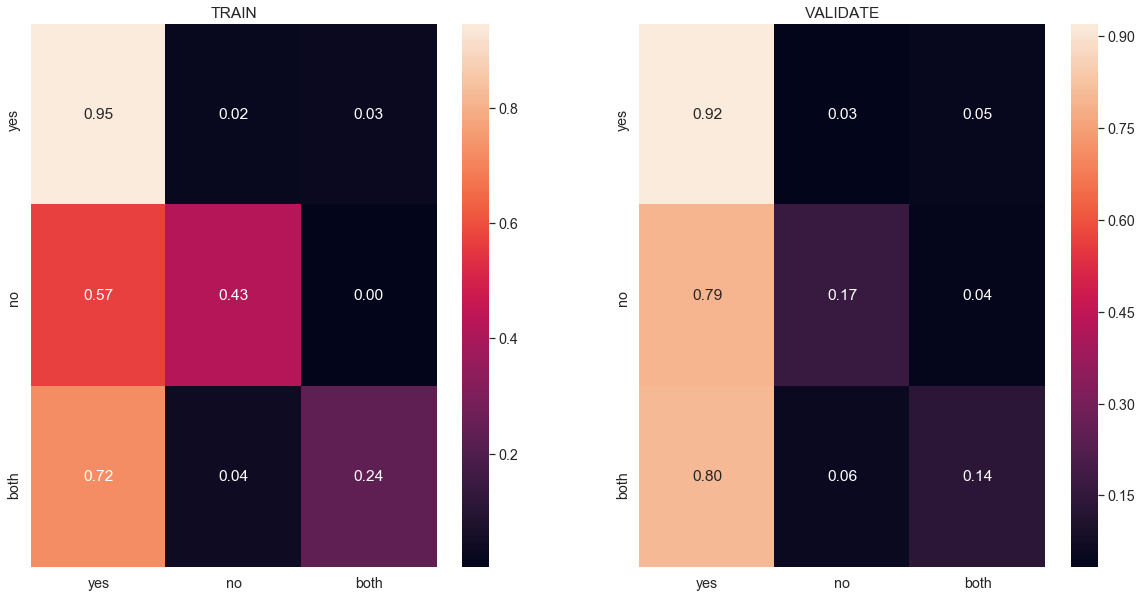

             precision    recall  f1-score   support

       both       0.44      0.14      0.21       645
         no       0.22      0.17      0.19       193
        yes       0.76      0.92      0.83      2275

avg / total       0.66      0.71      0.66      3113



In [34]:
evaluate_model(sv_poly, cv_train_df, y_train, cv_val_df, y_val)

Support Vector Machine with polynomial kernel does worse than the Logistic Regression.

#### Support Vector Machine with rbf-kernel

In [35]:
sv_rbf = SVC(kernel='rbf', class_weight='balanced', C=1.0, random_state=42).fit(cv_train_df, y_train)

Accuracy for predicting the train labels: 0.71
Accuracy for predicting the validate labels: 0.64


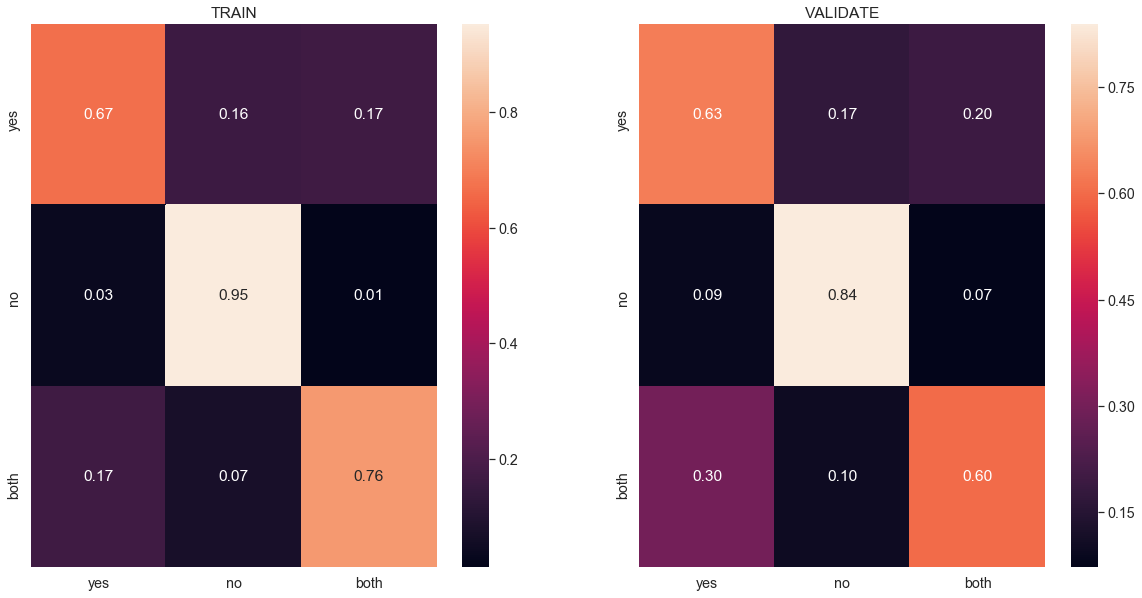

             precision    recall  f1-score   support

       both       0.46      0.60      0.52       645
         no       0.26      0.84      0.40       193
        yes       0.87      0.63      0.73      2275

avg / total       0.75      0.64      0.67      3113



In [36]:
evaluate_model(sv_rbf, cv_train_df, y_train, cv_val_df, y_val)

The rbf kernel does quite well. It's much worse than Logistic Regression at recognising 'yes' publications but is able to classify 'no' and 'both' quite okay.

#### Support Vector Machine with linear-kernel
Since Logistic Regression as a linear algorithm does kind of okay, the linear kernel is also tried.

In [37]:
sv_linear = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=42).fit(cv_train_df, y_train)

Accuracy for predicting the train labels: 0.73
Accuracy for predicting the validate labels: 0.63


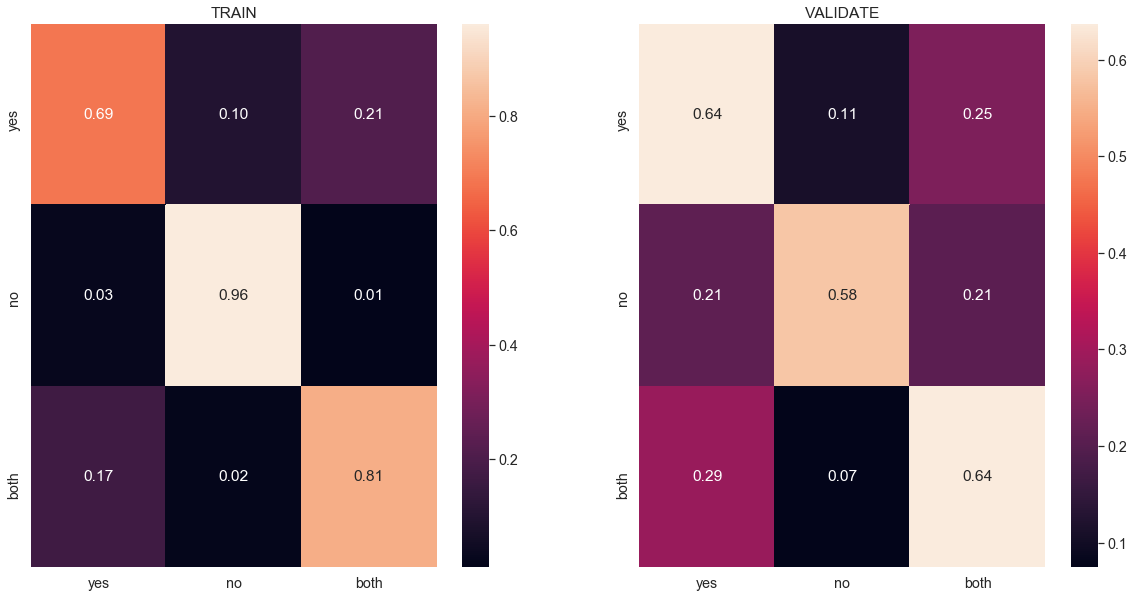

             precision    recall  f1-score   support

       both       0.40      0.64      0.49       645
         no       0.27      0.58      0.37       193
        yes       0.86      0.64      0.73      2275

avg / total       0.73      0.63      0.66      3113



In [38]:
evaluate_model(sv_linear, cv_train_df, y_train, cv_val_df, y_val)

SVM with linear kernel performs better than Logistic Regression.

### Logistic Regression with balanced classes
- the classes are equally balanced in the following as highly unbalanced classes might pose a problem

In [39]:
labelled_abstracts.groupby('significant').count()

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts
significant,,,,,,,,,,
both,4090,4090,4090,4090,4090,4090,4090,4090,4090,4090
no,1574,1574,1574,1574,1574,1574,1574,1574,1574,1574
yes,15087,15087,15086,15087,15087,15086,15086,15087,15087,15087


In [40]:
def get_different_portions(df, ratio):
    yes = ratio[0]
    no = ratio[1]
    both = ratio[2]
    
    yes_abstracts = df[df['significant'] == 'yes']
    no_abstracts = df[df['significant'] == 'no']
    both_abstracts = df[df['significant'] == 'both']
    
    yes_number = np.round((yes * len(no_abstracts)), decimals=0)
    no_number = no * len(no_abstracts)
    both_number = both * len(no_abstracts)
    
    yes_portion = yes_abstracts.sample(n=int(yes_number), random_state=42)
    no_portion = no_abstracts.sample(n=int(no_number), random_state=42)
    both_portion = both_abstracts.sample(n=int(both_number), random_state=42)
    
    print(f'No. abstracts "yes": {yes_number} | No. abstracts "no": {no_number} | No. abstracts "both": {both_number}')
    
    yes_portion.reset_index(drop=True, inplace=True)
    both_portion.reset_index(drop=True, inplace=True)
    no_portion.reset_index(drop=True, inplace=True)
    
    df = pd.concat((yes_portion, both_portion, no_portion), axis=0)
    
    y = df['significant']#
    X_data = df.drop('significant', axis=1)
    X = count_vect(X_data['abstract'])
    
    return X, y

In [41]:
X_equal, y_equal = get_different_portions(labelled_abstracts, [1,1,1])

No. abstracts "yes": 1574 | No. abstracts "no": 1574 | No. abstracts "both": 1574


In [42]:
logreg_equal = LogisticRegression(random_state=42).fit(X_equal, y_equal)

Accuracy for predicting the train labels: 0.82
Accuracy for predicting the validate labels: 0.61


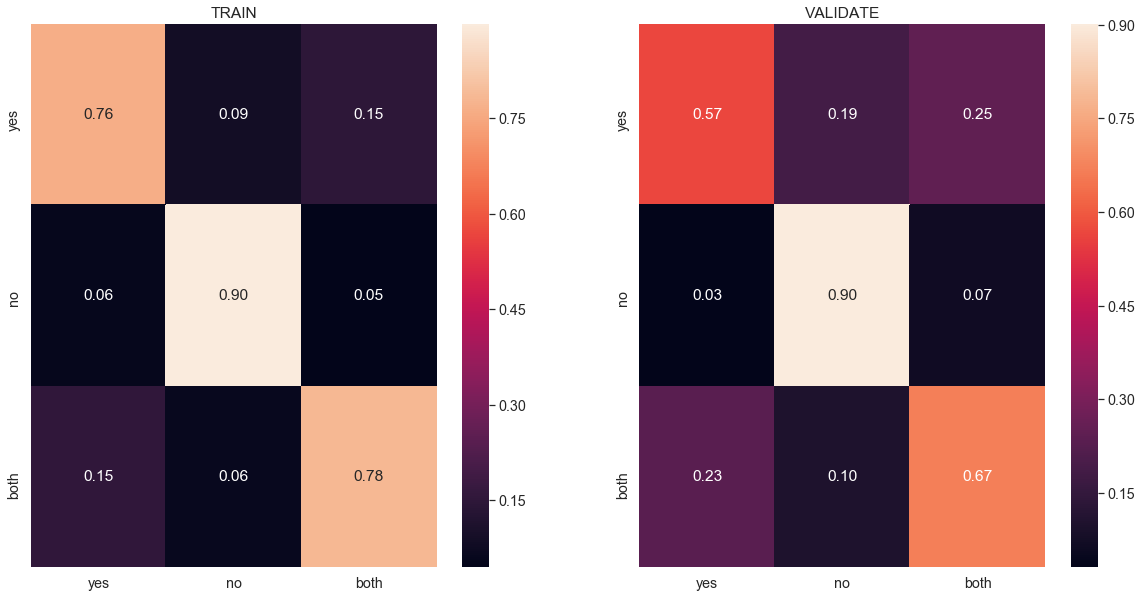

             precision    recall  f1-score   support

       both       0.43      0.67      0.52       645
         no       0.26      0.90      0.41       193
        yes       0.89      0.57      0.69      2275

avg / total       0.76      0.61      0.64      3113



In [43]:
evaluate_model(logreg_equal, X_equal, y_equal, cv_val_df, y_val)

With balanced classes the model is better able to differentiate between the different classes. However, SVM with kernel rbf still perform better.

### Logistic Regression with only the correlated features
- all features that do not have a linear realationship with the target are removed from the DataFrame
- remaining features: statistically, difference and significantly
- the data with balanced classes are used

In [44]:
def lin_features(df):
    lf = pd.DataFrame()
    lf['significant'] = df['significant']
    lf['statistically'] = df['statistically']
    lf['difference'] = df['difference']
    lf['significantly'] = df['significantly']
    lf['differences'] = df['differences']
    lf['observed'] = df['observed']
    lf['correlation'] = df['correlation']
    lf['reduction'] = df['reduction']
    lf['increase'] = df['increase']
    lf['decrease'] = df['decrease']
    lf['showed'] = df['showed']
    lf['association'] = df['association']
    lf['improvement'] = df['improvement']
    lf['study'] = df['study']
    return lf

In [45]:
train_lin = lin_features(X_equal)
val_lin = lin_features(cv_val_df)

In [46]:
logreg_lin = LogisticRegression(random_state=42).fit(train_lin, y_equal)

Accuracy for predicting the train labels: 0.68
Accuracy for predicting the validate labels: 0.59


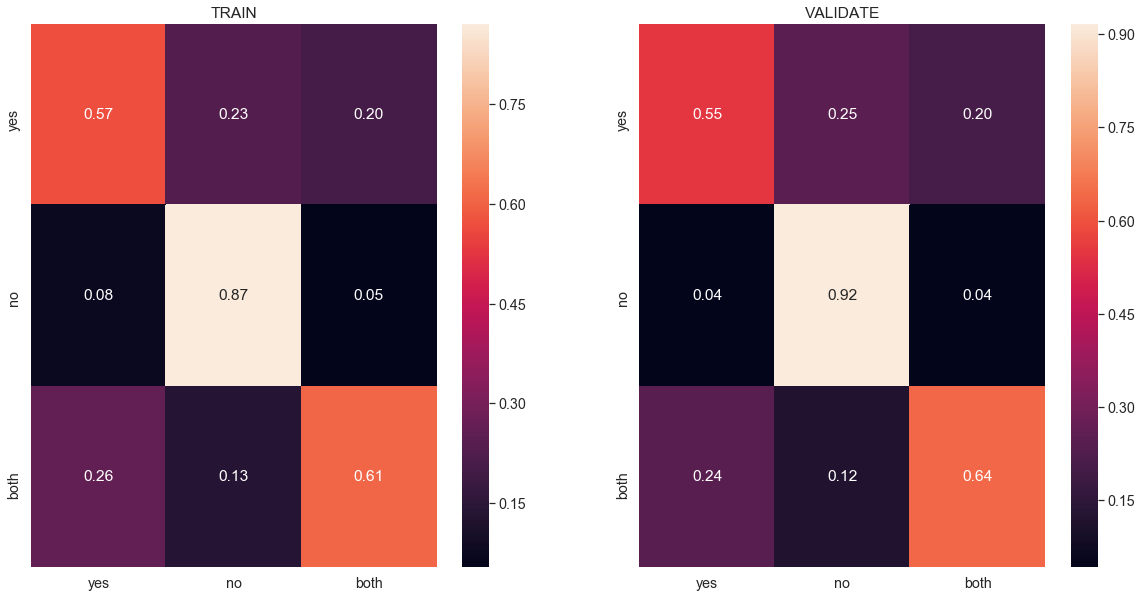

             precision    recall  f1-score   support

       both       0.47      0.64      0.54       645
         no       0.22      0.92      0.35       193
        yes       0.88      0.55      0.68      2275

avg / total       0.75      0.59      0.63      3113



In [47]:
evaluate_model(logreg_lin, train_lin, y_equal, val_lin, y_val)

Using only features with linear correlation did not improve performance.

C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy for predicting the train labels: 0.71
Accuracy for predicting the validate labels: 0.64


C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


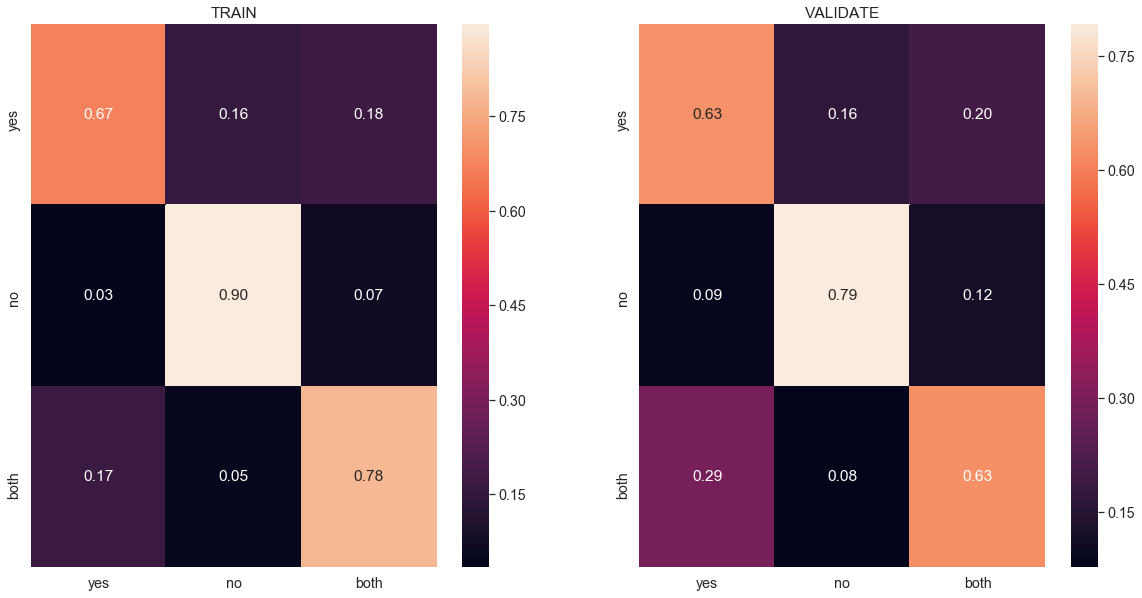

             precision    recall  f1-score   support

       both       0.45      0.63      0.53       645
         no       0.26      0.79      0.40       193
        yes       0.87      0.63      0.73      2275

avg / total       0.75      0.64      0.67      3113



In [48]:
vc = VotingClassifier(estimators=[('lr1', logreg_cv), ('lr2', sv_rbf)], voting='hard').fit(cv_train_df, y_train)
evaluate_model(vc, cv_train_df, y_train, cv_val_df, y_val)

C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy for predicting the train labels: 0.8
Accuracy for predicting the validate labels: 0.54


C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


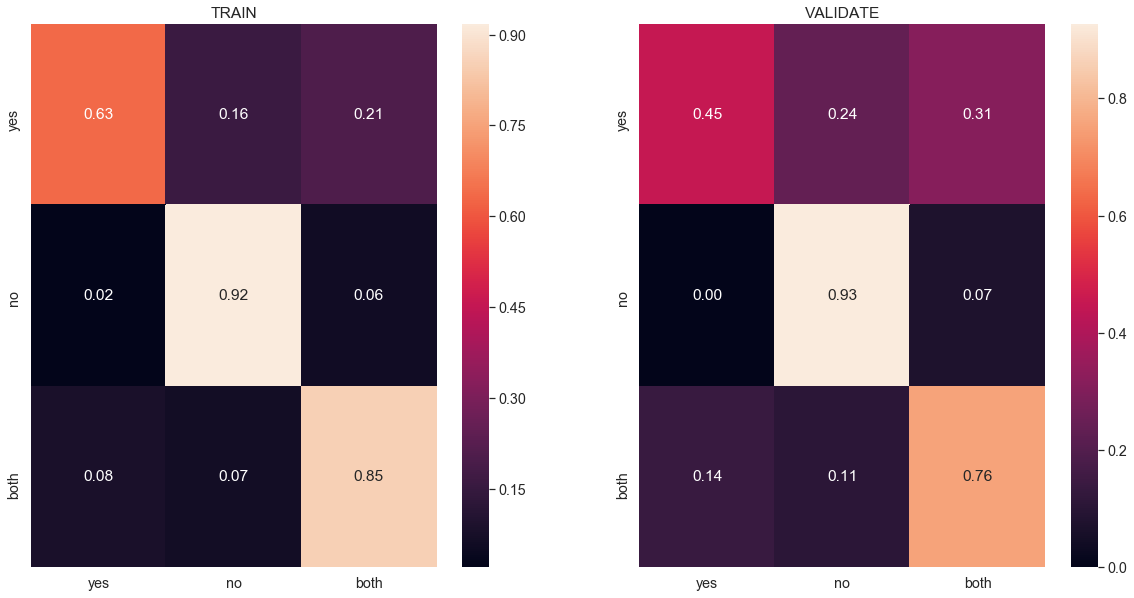

             precision    recall  f1-score   support

       both       0.40      0.76      0.52       645
         no       0.23      0.93      0.37       193
        yes       0.92      0.45      0.60      2275

avg / total       0.77      0.54      0.57      3113



In [49]:
vc_equal = VotingClassifier(estimators=[('lr1', logreg_equal), ('lr2', sv_rbf)], voting='hard').fit(X_equal, y_equal)
evaluate_model(vc_equal, X_equal, y_equal, cv_val_df, y_val)

In [50]:
X_2_1_1, y_2_1_1 = get_different_portions(labelled_abstracts, [2,1,1])

No. abstracts "yes": 3148 | No. abstracts "no": 1574 | No. abstracts "both": 1574


C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy for predicting the train labels: 0.75
Accuracy for predicting the validate labels: 0.61


C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


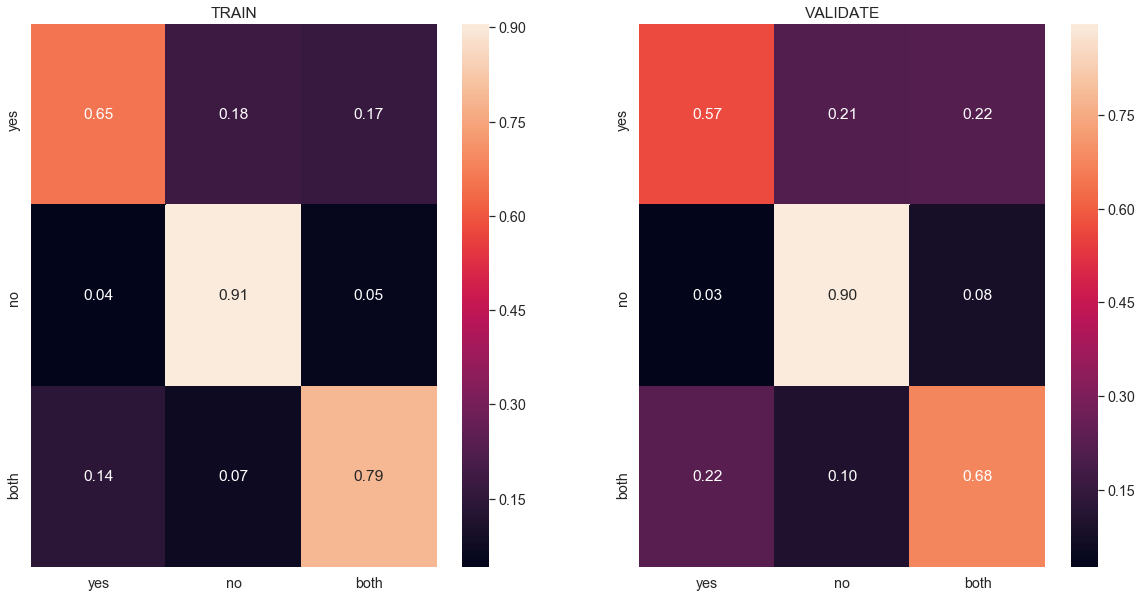

             precision    recall  f1-score   support

       both       0.46      0.68      0.55       645
         no       0.24      0.90      0.38       193
        yes       0.90      0.57      0.70      2275

avg / total       0.76      0.61      0.65      3113



In [51]:
vc_2_1_1 = VotingClassifier(estimators=[('lr1', logreg_equal), ('lr2', sv_rbf)], voting='hard').fit(X_2_1_1, y_2_1_1)
evaluate_model(vc_2_1_1, X_2_1_1, y_2_1_1, cv_val_df, y_val)

In [52]:
X_3_1_2, y_3_1_2 = get_different_portions(labelled_abstracts, [3,1,2])

No. abstracts "yes": 4722 | No. abstracts "no": 1574 | No. abstracts "both": 3148


C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy for predicting the train labels: 0.73
Accuracy for predicting the validate labels: 0.64


C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


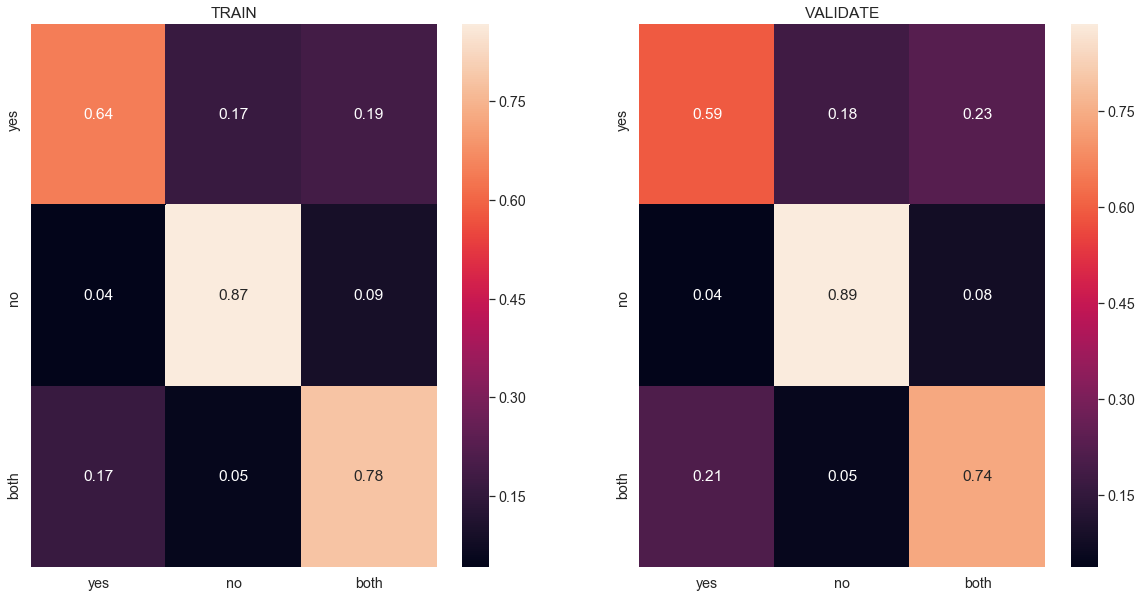

             precision    recall  f1-score   support

       both       0.47      0.74      0.58       645
         no       0.28      0.89      0.42       193
        yes       0.90      0.59      0.72      2275

avg / total       0.78      0.64      0.67      3113



In [53]:
vc_3_1_2 = VotingClassifier(estimators=[('lr1', logreg_equal), ('lr2', sv_rbf)], voting='hard').fit(X_3_1_2, y_3_1_2)
evaluate_model(vc_3_1_2, X_3_1_2, y_3_1_2, cv_val_df, y_val)

### Test of chosen model with unseen data

C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy for predicting the train labels: 0.65
Accuracy for predicting the validate labels: 0.62


C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


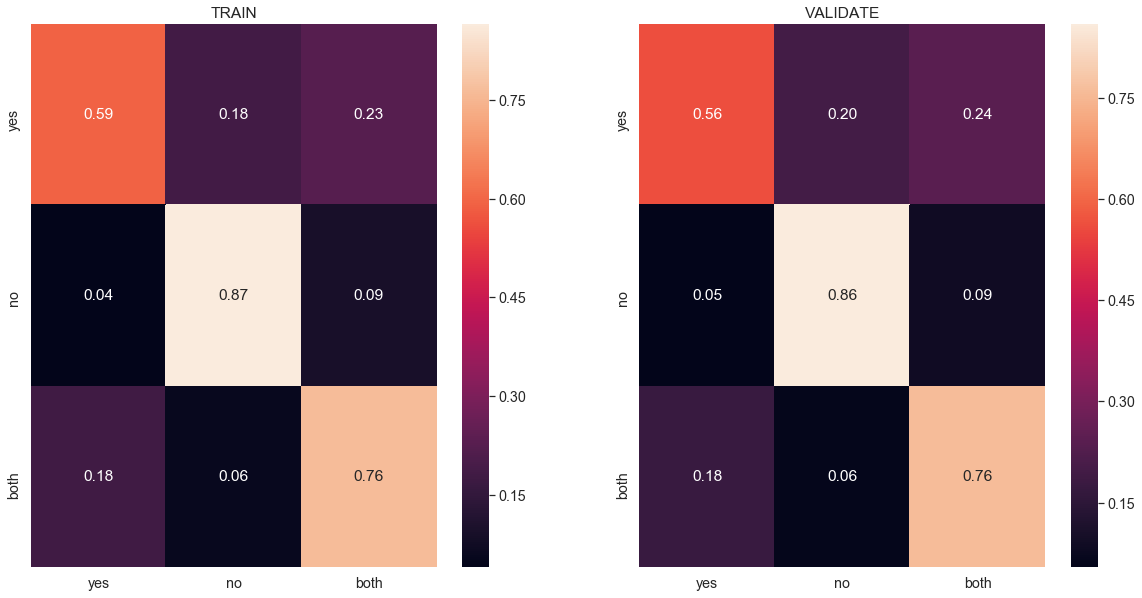

             precision    recall  f1-score   support

       both       0.44      0.76      0.56       588
         no       0.28      0.86      0.42       222
        yes       0.92      0.56      0.70      2303

avg / total       0.78      0.62      0.65      3113



In [54]:
evaluate_model(vc_3_1_2, cv_train_df, y_train, cv_test_df, y_test)

### Predicting significance of the unlabeled abstracts

In [55]:
unlabelled_abstracts.head()

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts
0,quality life hypoparathyroidism vokes author i...,30261328,2018.0,Bone,Quality of life in hypoparathyroidism,VokesT,VokesT,0.0,0.0,Hypoparathyroidism is a rare endocrine disorde...
58,primary prevention cardiovascular disease umbr...,30245517,2018.0,An Sist Sanit Navar,Primary prevention of cardiovascular disease: ...,MartinRuizE OlrydeLabryA EpsteinD,EpsteinD,0.0,0.0,BACKGROUND: The aim of this study is to determ...
68,vitamind status the time hospitalization for b...,30243543,2018.0,J Pediatr,Vitamin D Status at the Time of Hospitalizatio...,VoP KoppelC EspinolaJA MansbachJM CelednJC Has...,CamargoCAJr,0.0,0.0,OBJECTIVE: To investigate the association betw...
93,guirguisblake michael perdue coppola beil thom...,30234932,2018.0,Preventive Services Task Force [Internet],Guirguis-Blake JM Michael YL Perdue LA Coppola...,OBJECTIVE:Weconductedthissystematicreviewtosup...,2017toidentifyanymajorstudiespublishedintheint...,0.0,1.0,OBJECTIVE: We conducted this systematic review...
95,evaluation association vitamind receptor genet...,30234384,2018.0,Genet Test Mol Biomarkers,Evaluation of Association of Vitamin D Recepto...,RatheeshV SubramanianS PrakashPSG VictorDJ,VictorDJ,0.0,0.0,BACKGROUND: Periodontitis is a multifactorial ...


In [56]:
cv_unlabelled = count_vect(unlabelled_abstracts['abstract'])

In [57]:
unlabelled_abstracts['significant'] = vc.predict(cv_unlabelled)

C:\Users\Kaddi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [58]:
unlabelled_abstracts.head()

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts,significant
0,quality life hypoparathyroidism vokes author i...,30261328,2018.0,Bone,Quality of life in hypoparathyroidism,VokesT,VokesT,0.0,0.0,Hypoparathyroidism is a rare endocrine disorde...,no
58,primary prevention cardiovascular disease umbr...,30245517,2018.0,An Sist Sanit Navar,Primary prevention of cardiovascular disease: ...,MartinRuizE OlrydeLabryA EpsteinD,EpsteinD,0.0,0.0,BACKGROUND: The aim of this study is to determ...,no
68,vitamind status the time hospitalization for b...,30243543,2018.0,J Pediatr,Vitamin D Status at the Time of Hospitalizatio...,VoP KoppelC EspinolaJA MansbachJM CelednJC Has...,CamargoCAJr,0.0,0.0,OBJECTIVE: To investigate the association betw...,yes
93,guirguisblake michael perdue coppola beil thom...,30234932,2018.0,Preventive Services Task Force [Internet],Guirguis-Blake JM Michael YL Perdue LA Coppola...,OBJECTIVE:Weconductedthissystematicreviewtosup...,2017toidentifyanymajorstudiespublishedintheint...,0.0,1.0,OBJECTIVE: We conducted this systematic review...,both
95,evaluation association vitamind receptor genet...,30234384,2018.0,Genet Test Mol Biomarkers,Evaluation of Association of Vitamin D Recepto...,RatheeshV SubramanianS PrakashPSG VictorDJ,VictorDJ,0.0,0.0,BACKGROUND: Periodontitis is a multifactorial ...,yes


### Combining labeled and unlabeled abstracts

In [60]:
noa['significant'] = np.zeros((len(noa),1))

In [61]:
result = pd.concat((labelled_abstracts, unlabelled_abstracts), axis=0)

In [62]:
result = result.sort_index()

In [63]:
result = pd.concat((result, noa), axis=0)

In [64]:
result.reset_index(drop=True, inplace=True)

In [69]:
result.head()

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts,significant
0,quality life hypoparathyroidism vokes author i...,30261328,2018.0,Bone,Quality of life in hypoparathyroidism,VokesT,VokesT,0.0,0.0,Hypoparathyroidism is a rare endocrine disorde...,no
1,vitamind status and its association with seaso...,30261231,2018.0,Neurosci Lett,Vitamin D status and its association with seas...,GuY ZhuZ LuanX HeJ,HeJ,1.0,0.0,BACKGROUND: Vitamin D plays a key role in depr...,yes
2,vitamind levels active tuberculosis latent tub...,30260729,2018.0,Fetal Pediatr Pathol,Vitamin D Levels in Active TB Latent TB Non-TB...,BuonsensoD SaliM PataD MasielloE SalernoG Cecc...,ValentiniP,0.0,0.0,BACKGROUND: Growing evidence suggests that vit...,yes
3,correlation vitamind binding protein gene poly...,30259785,2018.0,Per Med,Correlation of vitamin D binding protein gene ...,ChuaychooB TungtrongchitrR KriengsinyosW Tunti...,ChupeerachC,0.0,0.0,AIM: The risk of vitamin D binding protein (DB...,both
4,vitamind status including epicalcitriol among ...,30259504,2018.0,Endokrynol Pol,Vitamin D status including 3-epi-25OHD3 among ...,KmieP MinkiewiczI SworczakK mijewskiMA KowalskiK,KowalskiK,1.0,0.0,INTRODUCTION: In the context of pleiotropic vi...,yes


In [68]:
result.to_csv('../data/labelled_data.csv')